In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import cv2
import time

plt.rcParams["savefig.pad_inches"] = 0

In [59]:
def rgba(color, alpha, background=np.array([255, 255, 255])):
    return tuple((1 - alpha) * background + alpha * np.array(color))

rgba((0, 0, 0), 0.3)

(178.5, 178.5, 178.5)

In [53]:
datas = pickle.load(open('datas.pkl', 'rb'))

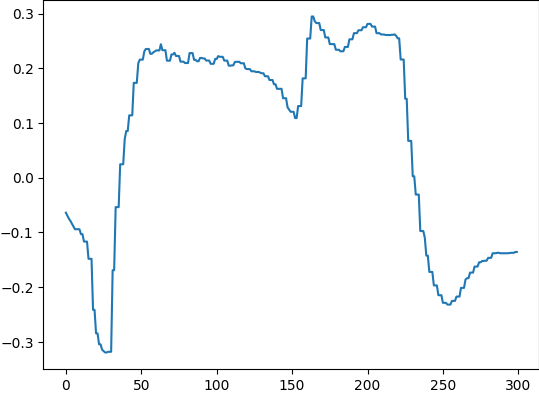

In [57]:
rudder_vel = [d["rel_angular_velocity"]["z"] for d in datas]
plt.plot(rudder_vel)

In [52]:
def matplotlib_draw():
    data = datas[0]

    min_position = {"x": 240, "y": 50}
    max_position = {"x": 300, "y": 100}

    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
    abs_position = data["abs_position"]
    abs_heading_angle = data["abs_heading_angle"]
    abs_wind_angle = data["abs_wind_angle"]
    rel_linear_velocity = data["rel_linear_velocity"]
    rel_angular_velocity = data["rel_angular_velocity"]

    s = 10

    ax.scatter(abs_position["x"], abs_position["y"], c="k", s=10, label="position")
    ax.arrow(abs_position["x"], abs_position["y"], np.cos(abs_heading_angle)*s, np.sin(abs_heading_angle)*s, color="g", width=.4, label="heading")
    ax.arrow(abs_position["x"], abs_position["y"], np.cos(abs_wind_angle)*s, np.sin(abs_wind_angle)*s, color="b", width=.4, label="wind")
    ax.arrow(abs_position["x"], abs_position["y"], rel_linear_velocity["x"], rel_linear_velocity["y"], color="r", width=.4, label="velocity")
    ax.set_xlim(min_position["x"], max_position["x"])
    ax.set_ylim(min_position["y"], max_position["y"])
    ax.set_aspect("equal")
    ax.axis("off")
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return data

%timeit matplotlib_draw();

9.47 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(-0.5, 499.5, 499.5, -0.5)

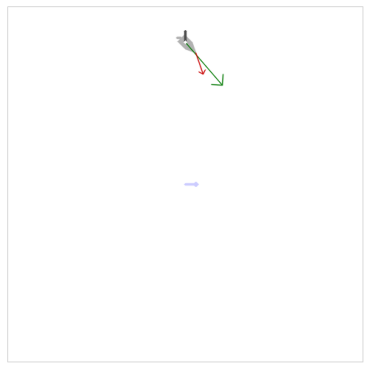

In [87]:
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (200, 0, 0)
BLUE = (0, 0, 255)
GREEN = (0, 120, 0)

def to_180(angle):
    return (angle + 180) % 360 - 180

def angle_to_vec(angle):
    return np.array([np.cos(angle), np.sin(angle)])

def rgba(color, alpha, background=np.array([255, 255, 255])):
    return tuple((1 - alpha) * background + alpha * np.array(color))

def display_sailboat(map_bounds, pos, heading_angle, sail_angle, rudder_angle, lin_vel, ang_vel, wind, size=500, padding=10):
    center = (map_bounds[0] + map_bounds[1]) / 2

    # Create a white image of size map_size pixels
    img = 255 + np.zeros((size, size, 3), np.uint8)

    # Scale the coordinates to fit the image
    def rescale_to_fit_the_map(x):
        return (x - map_bounds[0]) / (map_bounds[1] - map_bounds[0]) * (size - 2*padding) + padding
    pos = rescale_to_fit_the_map(pos)
    map_border = rescale_to_fit_the_map(map_bounds)
    map_center = rescale_to_fit_the_map(center)
    lin_vel = rescale_to_fit_the_map(map_bounds[0] + lin_vel)
    ang_vel = rescale_to_fit_the_map(map_bounds[0] + ang_vel)
    wind = wind / (map_bounds[1] - map_bounds[0]) * (size - 2*padding)

    # Draw a sailboat polygon using OpenCV functions
    boat_size = 10
    spike_coeff = 2
    phi = np.deg2rad(40)

    # Draw the borders
    cv2.rectangle(img, tuple(map_border[0].astype(np.int32)), tuple(map_border[1].astype(np.int32)), rgba(BLACK, .2), 1)

    # Draw the wind at the center of the map
    cv2.arrowedLine(img, tuple((map_center).astype(np.int32)), tuple((map_center + wind).astype(np.int32)), rgba(BLUE, .2), 2, tipLength=0.2, line_type=cv2.LINE_AA)

    # Draw the sailboat
    sailboat_pts = np.array([
        [pos + angle_to_vec(heading_angle + phi) * boat_size],
        [pos + angle_to_vec(heading_angle + (np.pi - phi)) * boat_size],
        [pos + angle_to_vec(heading_angle + (np.pi + phi)) * boat_size],
        [pos + angle_to_vec(heading_angle - phi) * boat_size],
        [pos + angle_to_vec(heading_angle) * spike_coeff*boat_size]
    ], dtype=np.int32)
    cv2.fillConvexPoly(img, sailboat_pts, rgba(BLACK, .3), lineType=cv2.LINE_AA)

    # Draw the sail
    sail_size = 15
    cv2.line(img, tuple(pos.astype(np.int32)), tuple((pos + angle_to_vec(np.pi + heading_angle + sail_angle) * sail_size).astype(np.int32)), rgba(BLACK, .7), 2, lineType=cv2.LINE_AA)

    # Draw the rudder
    rudder_size = 5
    rudder_center = pos + angle_to_vec(np.pi + heading_angle) * np.cos(phi) * boat_size # back of the boat
    cv2.line(img, tuple(rudder_center.astype(np.int32)), tuple((rudder_center + angle_to_vec(np.pi + heading_angle + rudder_angle)*rudder_size).astype(np.int32)), rgba(BLACK, .3), 2, lineType=cv2.LINE_AA)

    # Draw the velocities
    lin_vel_center = pos # center of the boat
    ang_vel_center = pos + angle_to_vec(heading_angle) * spike_coeff*boat_size # front of the boat
    cv2.arrowedLine(img, tuple(lin_vel_center.astype(np.int32)), tuple((lin_vel_center + lin_vel).astype(np.int32)), GREEN, 1, tipLength=.2, line_type=cv2.LINE_AA)
    cv2.arrowedLine(img, tuple(ang_vel_center.astype(np.int32)), tuple((ang_vel_center + ang_vel).astype(np.int32)), RED, 1, tipLength=.2, line_type=cv2.LINE_AA)

    # Draw the center of the sailboat
    cv2.circle(img, tuple(pos.astype(np.int32)), 2, WHITE, -1)

    return img

pos = np.array([270, 55], dtype=np.float32)
map_bounds = np.array([[240, 50], [300, 100]], dtype=np.float32)
wind = np.array([2, 0])
lin_vel = np.array([1, 1])*5
ang_vel = np.array([0, 1])*2

plt.imshow(display_sailboat(map_bounds, pos, np.deg2rad(45), np.deg2rad(45), np.deg2rad(-45), lin_vel, ang_vel, wind))
plt.axis('off')

# %timeit display_sailboat(map_bounds, pos, np.deg2rad(45), np.deg2rad(45), np.deg2rad(-45), lin_vel, ang_vel, wind);

(-0.5, 599.5, 599.5, -0.5)

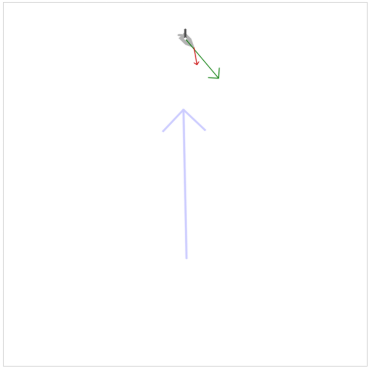

In [68]:
plt.imshow(display_sailboat(map_bounds, pos, np.deg2rad(45), np.deg2rad(45), np.deg2rad(-45), lin_vel, ang_vel, wind))
plt.axis('off')

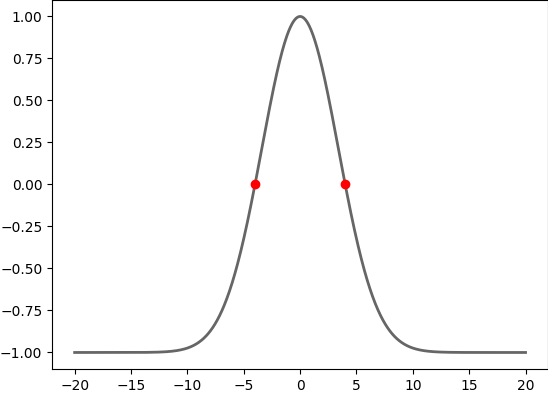

In [4]:
d = 4
mu = 0
tau = d**2/np.log(2)

x = np.linspace(-20, 20, 1000)
plt.plot(x, 2*np.exp(-(x-mu)**2/tau)-1, 'k-', lw=2, alpha=0.6, label='gaussian pdf', zorder=-1)
plt.scatter(np.sqrt(tau*np.log(2))+mu, 0, c='r')
plt.scatter(-np.sqrt(tau*np.log(2))+mu, 0, c='r')

In [77]:
frames = pickle.load(open('frames.pkl', 'rb'))
frames = np.array(frames).astype(np.uint8)
frames.shape

(817, 500, 500, 3)

In [100]:
imageio.help('mp4')

FFMPEG - Many video formats and cameras (via ffmpeg)

    Read/Write ImageResources using FFMPEG.

    See :mod:`imageio.plugins.ffmpeg`



In [51]:
from IPython.display import HTML
import uuid
import imageio

frames = pickle.load(open('frames.pkl', 'rb'))
frames = np.array(frames).astype(np.uint8)
print(frames.shape)

rand_id = str(uuid.uuid4())
print(rand_id)
imageio.mimwrite(f'videos/{rand_id}.mp4', frames[:, ::-1, :, :], fps=60)
HTML(f"""
<video width="500" height="500" controls>
  <source src="videos/{rand_id}.mp4">
</video>
""")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


(300, 500, 500, 3)
f8003833-7315-4bca-b054-a70462185c64


In [18]:
from IPython.display import HTML
import imageio
imageio.mimwrite('test2.mp4', frames, fps=30)
HTML("""
<video width="480" height="360" controls>
  <source src="{0}">
</video>
""".format('./test2.mp4'))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [60]:
import numpy as np

In [67]:
from pydantic.utils import deep_update

def rgba(color, alpha, background=np.array([255, 255, 255])):
    return tuple((1 - alpha) * background + alpha * np.array(color))

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (200, 0, 0)
BLUE = (0, 0, 255)
GREEN = (0, 120, 0)

opts = {
    "boat": {
        "color": rgba(BLACK, .3),
        "spike_coef": 2,
        "size": 10,
        "phi": np.deg2rad(40)
    },
    "rudder": {
        "color": rgba(BLACK, .3),
        "width": 2,
        "height": 10,
    },
    "sail": {
        "color": rgba(BLACK, .7),
        "width": 2,
        "height": 15,
    },
    "wind": {
        "color": rgba(BLUE, .2),
        "width": 2,
    },
}

new_opts = {
    "boat": {
        "size": 12
    },
}

deep_update(opts, new_opts)

{'boat': {'color': (178.5, 178.5, 178.5),
  'spike_coef': 2,
  'size': 12,
  'phi': 0.6981317007977318},
 'rudder': {'color': (178.5, 178.5, 178.5), 'width': 2, 'height': 10},
 'sail': {'color': (76.50000000000001, 76.50000000000001, 76.50000000000001),
  'width': 2,
  'height': 15},
 'wind': {'color': (204.0, 204.0, 255.0), 'width': 2}}